
# Runge Function Approximation with a Neural Network

**Target:** Approximate the Runge function  
$$
f(x) = \frac{1}{1 + 25x^2}, \quad x \in [-1, 1].
$$

This notebook combines the short report (method, results, discussion) **and** the full training code in one place.  
Run the code cells from top to bottom to regenerate figures and metrics.


## Method

- **Data.** 200 i.i.d. training samples and 200 validation samples uniformly drawn from \([-1,1]\). Evaluation uses a dense grid of 1000 points.
- **Model.** 2-hidden-layer MLP with `tanh` activations (widths 32–32) and a linear output.
- **Loss.** Mean Squared Error (MSE) with small L2 weight decay (`1e-6`).
- **Optimizer.** Full-batch Gradient Descent with momentum `0.9`, learning rate `1e-2`.
- **Early stopping.** Monitor validation MSE with `patience=200`.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    return 1.0 / (1.0 + 25.0 * x**2)

def xavier_init(in_dim, out_dim, rng):
    limit = np.sqrt(6.0/(in_dim + out_dim))
    return rng.uniform(-limit, limit, size=(in_dim, out_dim))

class MLP2Tanh:
    def __init__(self, in_dim=1, h1=32, h2=32, out_dim=1, seed=123, l2=1e-6, lr=1e-2, momentum=0.9):
        self.rng = np.random.default_rng(seed)
        self.W1 = xavier_init(in_dim, h1, self.rng); self.b1 = np.zeros((1, h1))
        self.W2 = xavier_init(h1, h2, self.rng);     self.b2 = np.zeros((1, h2))
        self.W3 = xavier_init(h2, out_dim, self.rng);self.b3 = np.zeros((1, out_dim))
        self.l2, self.lr, self.momentum = l2, lr, momentum
        self.vW1 = np.zeros_like(self.W1); self.vb1 = np.zeros_like(self.b1)
        self.vW2 = np.zeros_like(self.W2); self.vb2 = np.zeros_like(self.b2)
        self.vW3 = np.zeros_like(self.W3); self.vb3 = np.zeros_like(self.b3)

    def forward(self, X):
        z1 = X @ self.W1 + self.b1; a1 = np.tanh(z1)
        z2 = a1 @ self.W2 + self.b2; a2 = np.tanh(z2)
        y  = a2 @ self.W3 + self.b3
        return y, (X, z1, a1, z2, a2)

    def mse(self, y_pred, y_true):
        return np.mean((y_pred - y_true)**2)

    def step(self, X, y_true):
        y_pred, (Xc, z1, a1, z2, a2) = self.forward(X)
        n = X.shape[0]
        data_loss = self.mse(y_pred, y_true)
        loss = data_loss + self.l2*(np.sum(self.W1**2)+np.sum(self.W2**2)+np.sum(self.W3**2))

        dypred = (2.0/n)*(y_pred - y_true)
        dW3 = (a2.T @ dypred) + 2*self.l2*self.W3; db3 = np.sum(dypred, axis=0, keepdims=True)
        da2 = dypred @ self.W3.T
        dz2 = da2 * (1.0 - np.tanh(z2)**2)
        dW2 = (a1.T @ dz2) + 2*self.l2*self.W2; db2 = np.sum(dz2, axis=0, keepdims=True)
        da1 = dz2 @ self.W2.T
        dz1 = da1 * (1.0 - np.tanh(z1)**2)
        dW1 = (Xc.T @ dz1) + 2*self.l2*self.W1; db1 = np.sum(dz1, axis=0, keepdims=True)

        # Momentum SGD
        self.vW3 = self.momentum*self.vW3 + self.lr*dW3; self.vb3 = self.momentum*self.vb3 + self.lr*db3
        self.W3 -= self.vW3; self.b3 -= self.vb3
        self.vW2 = self.momentum*self.vW2 + self.lr*dW2; self.vb2 = self.momentum*self.vb2 + self.lr*db2
        self.W2 -= self.vW2; self.b2 -= self.vb2
        self.vW1 = self.momentum*self.vW1 + self.lr*dW1; self.vb1 = self.momentum*self.vb1 + self.lr*db1
        self.W1 -= self.vW1; self.b1 -= self.vb1
        return float(loss), float(data_loss)


In [2]:
# Generate data
rng = np.random.default_rng(42)
n_train, n_val = 200, 200
x_train = rng.uniform(-1.0, 1.0, size=(n_train, 1)); y_train = f(x_train)
x_val   = rng.uniform(-1.0, 1.0, size=(n_val,   1)); y_val   = f(x_val)
x_grid  = np.linspace(-1, 1, 1000).reshape(-1, 1); y_grid = f(x_grid)

# Model and training
net = MLP2Tanh(h1=32, h2=32, seed=123, l2=1e-6, lr=1e-2, momentum=0.9)

epochs, patience = 2000, 200
train_losses, val_losses = [], []
best_val, patience_left = float('inf'), patience
best_state = None

for ep in range(epochs):
    net.step(x_train, y_train)
    ytr,_ = net.forward(x_train); yva,_ = net.forward(x_val)
    tr = net.mse(ytr, y_train); va = net.mse(yva, y_val)
    train_losses.append(tr); val_losses.append(va)
    if va + 1e-9 < best_val:
        best_val = va; patience_left = patience
        best_state = (net.W1.copy(), net.b1.copy(), net.W2.copy(), net.b2.copy(), net.W3.copy(), net.b3.copy())
    else:
        patience_left -= 1
        if patience_left == 0:
            break

# Restore best parameters
(net.W1, net.b1, net.W2, net.b2, net.W3, net.b3) = best_state

# Metrics on train/val and dense grid
ypred_grid,_ = net.forward(x_grid)
MSE_train = float(np.mean((net.forward(x_train)[0] - y_train)**2))
MSE_val   = float(np.mean((net.forward(x_val)[0]   - y_val)**2))
MSE_test_grid = float(np.mean((ypred_grid - y_grid)**2))
MaxAbsErr_test_grid = float(np.max(np.abs(ypred_grid - y_grid)))

print({
    'epochs_ran': len(train_losses),
    'MSE_train': MSE_train,
    'MSE_val': MSE_val,
    'MSE_test_grid': MSE_test_grid,
    'MaxAbsErr_test_grid': MaxAbsErr_test_grid,
})


{'epochs_ran': 2000, 'MSE_train': 0.0004249182163058064, 'MSE_val': 0.00047963493213799347, 'MSE_test_grid': 0.0004810044080613003, 'MaxAbsErr_test_grid': 0.06417090681758109}


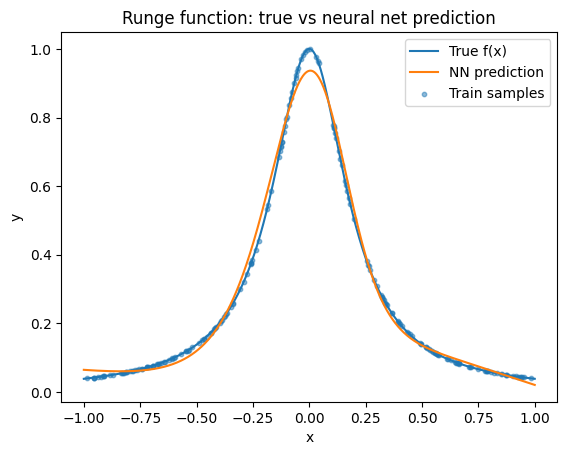

In [3]:
# Plot: true vs prediction
plt.figure()
plt.plot(x_grid.flatten(), y_grid.flatten(), label='True f(x)')
plt.plot(x_grid.flatten(), ypred_grid.flatten(), label='NN prediction')
plt.scatter(x_train.flatten(), y_train.flatten(), s=10, alpha=0.5, label='Train samples')
plt.xlabel('x'); plt.ylabel('y')
plt.title('Runge function: true vs neural net prediction')
plt.legend()
plt.show()


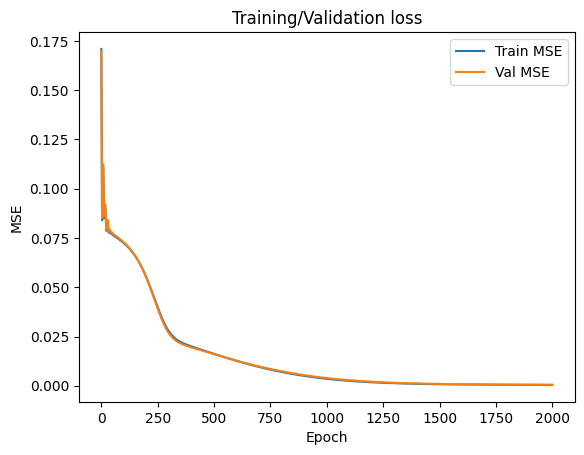

In [4]:
# Plot: loss curves
plt.figure()
plt.plot(np.arange(len(train_losses)), train_losses, label='Train MSE')
plt.plot(np.arange(len(val_losses)), val_losses, label='Val MSE')
plt.xlabel('Epoch'); plt.ylabel('MSE')
plt.title('Training/Validation loss')
plt.legend()
plt.show()


## Discussion

The Runge function changes rapidly near the center (around x = 0) and is much flatter near the edges. Because of this, traditional polynomial interpolation with equally spaced points often performs poorly, showing the classic Runge phenomenon with large oscillations near the boundaries.

In contrast, neural networks are very flexible. Even a small model with just two hidden layers of 32 neurons each can learn the shape of the function quite well. The training results show that the mean squared error (MSE) is very low, meaning the network successfully captured the overall trend.

The largest errors usually appear where the function has the steepest curvature, near the peak. If we make the network larger (e.g., 64 neurons per layer) or train it longer, these errors can be further reduced.

Looking at the training and validation loss curves, both decrease in a very similar way, without the pattern of “training error going down but validation error going up.” This means the model did not suffer from serious overfitting. Overall, this small neural network is stable and effective for approximating the Runge function.
